## SAR time series Analysis for detecting deforestation

This notebook is used for creating charts and visualizations that will appear on the thesis document


In [1]:
#Importing libraries
import ee
import os
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
import datetime

In [2]:
# Secondary libraries for plotting and visualization
import geemap
import matplotlib.pyplot as plt
#import seaborn as sns
import math
import folium

In [3]:
# triger the GEE API
ee.Initialize()

### Pre-processing

In [4]:
#Acording to SAR Handbook for forest and land cover applications, 
#it is better to work with gamma zero backscatter instead of sigma zero
# Also reduce noise speackle is also recommended

#### Functions to apply to the images before create the timeseries dataset

In [5]:
#Functions to reduce speckle 
# taken from https://github.com/adugnag/gee_s1_ard/
# simple median boxcar filter
def boxcar(img):

    KERNEL_SIZE = 5
    
    bandNames = img.bandNames().remove('angle')
      #Define a boxcar kernel
    kernel = ee.Kernel.square((KERNEL_SIZE/2), units='pixels', normalize=True)
     #Apply boxcar
    output = img.select(bandNames).convolve(kernel).rename(bandNames)
    return img.addBands(output, None, True)

def gammamap(img): 
    
    KERNEL_SIZE = 5
    enl = 5
    bandNames = img.bandNames().remove('angle')
    
    #local mean
    reducers = ee.Reducer.mean().combine( \
                      reducer2= ee.Reducer.stdDev(), \
                      sharedInputs= True
                      )
    stats = (img.select(bandNames).reduceNeighborhood( \
                      reducer= reducers, \
                          kernel= ee.Kernel.square(KERNEL_SIZE/2,'pixels'), \
                              optimization= 'window'))
    meanBand = bandNames.map(lambda bandName: ee.String(bandName).cat('_mean'))
    stdDevBand = bandNames.map(lambda bandName:  ee.String(bandName).cat('_stdDev'))
        
    z = stats.select(meanBand)
    sigz = stats.select(stdDevBand)
    
    #local observed coefficient of variation
    ci = sigz.divide(z)
    #noise coefficient of variation (or noise sigma)
    cu = 1.0/math.sqrt(enl)
    #threshold for the observed coefficient of variation
    cmax = math.sqrt(2.0) * cu
    cu = ee.Image.constant(cu)
    cmax = ee.Image.constant(cmax)
    enlImg = ee.Image.constant(enl)
    oneImg = ee.Image.constant(1)
    twoImg = ee.Image.constant(2)

    alpha = oneImg.add(cu.pow(2)).divide(ci.pow(2).subtract(cu.pow(2)))

    #Implements the Gamma MAP filter described in equation 11 in Lopez et al. 1990
    q = img.select(bandNames).expression('z**2 * (z * alpha - enl - 1)**2 + 4 * alpha * enl * b() * z', { 'z': z,  'alpha':alpha,'enl': enl})
    rHat = z.multiply(alpha.subtract(enlImg).subtract(oneImg)).add(q.sqrt()).divide(twoImg.multiply(alpha))
  
    #if ci <= cu then its a homogenous region ->> boxcar filter
    zHat = (z.updateMask(ci.lte(cu))).rename(bandNames)
    #if cmax > ci > cu then its a textured medium ->> apply Gamma MAP filter
    rHat = (rHat.updateMask(ci.gt(cu)).updateMask(ci.lt(cmax))).rename(bandNames)
    #ci>cmax then its strong signal ->> retain
    x = img.select(bandNames).updateMask(ci.gte(cmax)).rename(bandNames)  
    #Merge
    output = ee.ImageCollection([zHat,rHat,x]).sum()
    return img.addBands(output, None, True)

def RefinedLee(img):
   
    bandNames = img.bandNames().remove('angle')

    def inner(b):

        scene = img.select([b]);
    
        # scene must be linear, i.e. not in dB!
        # Set up 3x3 kernels 
        
        weights3 = ee.List.repeat(ee.List.repeat(1,3),3);
        kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False);
  
        mean3 = scene.reduceNeighborhood(ee.Reducer.mean(), kernel3);
        variance3 = scene.reduceNeighborhood(ee.Reducer.variance(), kernel3);
  
        # Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
        sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]]);
  
        sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False);
  
        # Calculate mean and variance for the sampled windows and store as 9 bands
        sample_mean = mean3.neighborhoodToBands(sample_kernel); 
        sample_var = variance3.neighborhoodToBands(sample_kernel);
  
        # Determine the 4 gradients for the sampled windows
        gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs();
        gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs());
        gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs());
        gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs());
  
        # And find the maximum gradient amongst gradient bands
        max_gradient = gradients.reduce(ee.Reducer.max());
  
        # Create a mask for band pixels that are the maximum gradient
        gradmask = gradients.eq(max_gradient);
  
        # duplicate gradmask bands: each gradient represents 2 directions
        gradmask = gradmask.addBands(gradmask);
  
        # Determine the 8 directions
        directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1);
        directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2));
        directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3));
        directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4));
        
        # The next 4 are the not() of the previous 4
        directions = directions.addBands(directions.select(0).Not().multiply(5));
        directions = directions.addBands(directions.select(1).Not().multiply(6));
        directions = directions.addBands(directions.select(2).Not().multiply(7));
        directions = directions.addBands(directions.select(3).Not().multiply(8));
  
        # Mask all values that are not 1-8
        directions = directions.updateMask(gradmask);
  
        # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
        directions = directions.reduce(ee.Reducer.sum());  
  
        sample_stats = sample_var.divide(sample_mean.multiply(sample_mean));
  
        #Calculate localNoiseVariance
        sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0]);
  
        # Set up the 7*7 kernels for directional statistics
        rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4));
  
        diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0], [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]]);
  
        rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False);
        diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False);
  
        # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
        dir_mean = scene.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1));
        dir_var = scene.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1));
  
        dir_mean = dir_mean.addBands(scene.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)));
        dir_var = dir_var.addBands(scene.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)));
  
        # and add the bands for rotated kernels
        for i in range(1, 4):
            dir_mean = dir_mean.addBands(scene.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
            dir_var = dir_var.addBands(scene.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
            dir_mean = dir_mean.addBands(scene.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
            dir_var = dir_var.addBands(scene.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

  
        # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
        dir_mean = dir_mean.reduce(ee.Reducer.sum());
        dir_var = dir_var.reduce(ee.Reducer.sum());
  
        # A finally generate the filtered value
        varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))
  
        b = varX.divide(dir_var)
        result = dir_mean.add(b.multiply(scene.subtract(dir_mean)))
  
        return result.arrayProject([0]).arrayFlatten([['sum']]).float()
    
    result = ee.ImageCollection(bandNames.map(inner)).toBands().rename(bandNames).copyProperties(img)
    
    return img.addBands(result, None, True) 

In [6]:
#function to convert sigma to gamma zero
# taken from DETER SAR github
def toGamma0(img):
    
    vv_gamma0=img.select('VV').subtract(img.select('angle').multiply(np.pi/180.0).cos().log10().multiply(10.0))
    vh_gamma0=img.select('VH').subtract(img.select('angle').multiply(np.pi/180.0).cos().log10().multiply(10.0))
    
    return img.addBands(vv_gamma0.rename('VVg0')).addBands(vh_gamma0.rename('VHg0')).copyProperties(img).copyProperties(img,['system:time_start'])

In [7]:
#function to convert db to power scale (recommended by SAR Handbook)
def toPower(img):
    
    base = 10.0
    
    #operation
    
    vv_power = ee.Image(base).pow(img.select('VVg0').divide(base)).rename('VV_pow')
    vh_power = ee.Image(base).pow(img.select('VHg0').divide(base)).rename('VH_pow')
    
    return img.addBands(vv_power).addBands(vh_power).copyProperties(img).copyProperties(img,['system:time_start'])
    

In [8]:
#function to convert power scale to db (recommended by SAR Handbook)

def toDb(img):
    
    base = 10
    
    VV_fdb = ee.Image(base).multiply(img.select('VV_pow').log10()).rename('VV_fdb')
    VH_fdb = ee.Image(base).multiply(img.select('VH_pow').log10()).rename('VH_fdb')
    
    return img.addBands(VV_fdb).addBands(VH_fdb).copyProperties(img).copyProperties(img,['system:time_start'])

In [9]:
#function to create the RFDI band
def rfdi(img):
    num = img.select('VV_pow').subtract(img.select('VH_pow'))
    den = img.select('VV_pow').add(img.select('VH_pow'))
    rfdi = num.divide(den).rename('rfdi')
    return img.addBands(rfdi).copyProperties(img).copyProperties(img,['system:time_start'])
    

In [10]:
#function to create mosaic with the same date in the AOI extend
def mosaicByDate(imgs):
    imgList = imgs.toList(imgs.size())
    unique_dates = imgList.map(lambda im: ee.Image(im).date().format("YYYY-MM-dd")).distinct()
    
    def mosaic_imlist(d):
        d = ee.Date(d)
        im = imgs.filterDate(d, d.advance(1, "day")).mosaic() 
        return im.set(
        "system:time_start", d.millis(), 
        "system:id", d.format("YYYY-MM-dd"));

    return ee.ImageCollection(unique_dates.map(mosaic_imlist))

#### Period of study and AOI

In [11]:
# defining period of study

startDate = "2021-01-01"; #no image before
endDate = "2022-10-01"; #exclusive = ie., until 2022-09-30

In [12]:
# Area of interest
#studyArea = ee.FeatureCollection("projects/ee-geeric/assets/data/AOI") #loaded from GEE assests
studyArea = ee.FeatureCollection("projects/ee-geeric/assets/data/test_region_forest")


# choose a path for your output directory. This is where you will have saved all the images in the collection

outdir = '/home/sepal-user/My_files/Outputs'

#### Aplying functions and filters

In [13]:
#Getting the S1 Image Collection

S1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterBounds(studyArea).filterDate(ee.Date(startDate), ee.Date(endDate))
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) # only descending as ascending images are not available for 2022
          .filterMetadata('transmitterReceiverPolarisation', 'equals', ['VV', 'VH'])
          .filterMetadata('resolution_meters', 'equals', 10)
          .map(lambda image:image.clip(studyArea.geometry()))
          .map(toGamma0))


countS1 = S1.size()
print('Number of images in the collection: ', str(countS1.getInfo())+'\n')


Number of images in the collection:  74



In [14]:
#separate the original VVg0 and VHg0 for further operations
S1g0=S1.select(['VVg0', 'VHg0'])
print(S1g0.first().bandNames().getInfo())

['VVg0', 'VHg0']


In [15]:
# Apply conversion to power before speckle reduction

#S1g0_pow = S1g0.map(toPower).map(toGamma0).map(toPower).map(rfdi)
S1g0_pow=S1g0.map(toPower)
print(S1g0_pow.first().bandNames().getInfo())



['VVg0', 'VHg0', 'VV_pow', 'VH_pow']


In [16]:
#Apply refinedLee filter for reducing speckle
S1g0_N_filter = S1g0_pow.select(['VV_pow', 'VH_pow']).map(RefinedLee)
print(S1g0_N_filter.first().bandNames().getInfo())

['VV_pow', 'VH_pow']


In [17]:
# Get the RFDI band and the VV and VH filtered bands in db
S1g0_index = S1g0_N_filter.map(rfdi).map(toDb)
print(S1g0_index.first().bandNames().getInfo())

['VV_pow', 'VH_pow', 'rfdi', 'VV_fdb', 'VH_fdb']


In [18]:
#Combine collections
S1processed = S1g0.combine(S1g0_index)
print(S1processed.first().bandNames().getInfo())

['VVg0', 'VHg0', 'VV_pow', 'VH_pow', 'rfdi', 'VV_fdb', 'VH_fdb']


In [19]:
#Visualization of the first Image of the collection
Map = geemap.Map()
first_image = S1processed.first()

vis_params = { 'bands':['VVg0', 'VHg0', 'VVg0'],'min':-25.0, 'max':0}

Map.addLayer(first_image, vis_params, "First image Collection")
Map.setCenter(-76.686, 5.026, 12)
Map

Map(center=[5.026, -76.686], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

### Create the timeseries dataset by band

In [20]:
#Select and filter the collections by band

S1_vvf = S1processed.select(['VV_fdb'])

S1_vhf = S1processed.select(['VH_fdb'])

S1_vvg0 = S1processed.select(['VVg0'])

S1_vhg0 = S1processed.select(['VHg0'])

S1_rfdi = S1processed.select(['rfdi'])

In [21]:
#deleting unnecessary objects
del S1, countS1, S1g0, S1g0_N_filter, S1g0_index, S1processed


In [22]:
#convert the collections to lists and get the dates

collections =[S1_vvf, S1_vhf, S1_vvg0, S1_vhg0, S1_rfdi]
list_c = []
list_dates = []

for c in collections:
   
    ctol = c.toList(c.size())
    unique_dates = ctol.map(lambda im:ee.Image(im).date().format("YYYY-MM-dd")).distinct()
    date_list = unique_dates.getInfo()
    date_list.sort()

    #variable_name = [k for k, v in locals().items() if v == c][0] 
    #newname = 'list_'+variable_name
    
    list_c.append(ctol)
    list_dates.append(date_list)
    
#    print("Your variable name is " + variable_name)
#    print("Newname is " + newname)
    
#----------------------------------- 
S1_vv_list = list_c[0] 
S1_vh_list = list_c[1]  
S1_vvg0_list = list_c[2] 
S1_vhg0_list = list_c[3] 
S1_rfdi_list = list_c[4] 

S1_vv_dates = list_dates[0] 
S1_vh_dates = list_dates[1] 
S1_vvg0_dates = list_dates[2] 
S1_vhg0_dates = list_dates[3] 
S1_rfdi_dates = list_dates[4] 

In [ ]:
a = S1processed.first().bandNames()
#print(a.getInfo())
print ('esto es un texto '+ str(a.getInfo()[0]))

In [ ]:
# cleaning memory
del S1_vv_list, S1_vh_list, S1_vvg0_list, S1_vhg0_list, S1_vh_dates, S1_vvg0_dates, S1_vhg0_dates

In [23]:
del list_dates, list_c,collections

### processing

### create charts from the timeseries dataset

In [ ]:
# timeseries backscatter behavour in a point of interest 
poi = ee.Geometry.Point(-76.7031058, 5.0173587).buffer(100)

In [ ]:
# function for creating charts

def poi_mean(img):
    
    band = 'rfdi' # ['VVg0', 'VHg0', 'rfdi', 'VV_fdb', 'VH_fdb'] Change it for each band
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=30).get(band)
    #mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=30).get('VHg0')
    
    return img.set('date', img.date().format()).set('data',mean)

In [ ]:
#how to apply the above to every dataset?

testl = []
for c in collections:
    
    poi_reduced_imgs = c.map(poi_mean)
    nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','data']).values().get(0)
    testl.append(nested_list)
    
testl

dft = pd.DataFrame(testl.getInfo())
#dft = pd.DataFrame(nested_list.getInfo(), columns=['date','meandata'])
#dft['date'] = pd.to_datetime(df['date'])
#dft = df.set_index('date')
dft
    

In [ ]:
# applying the function for reducing the collection
#poi_reduced_vhg0 = S1_vhg0.map(poi_mean)
#poi_reduced_vvg0 = S1_vvg0.map(poi_mean)
#poi_reduced_vhf = S1_vhf.map(poi_mean)
#poi_reduced_vvf = S1_vvf.map(poi_mean)
poi_reduced_rfdi = S1_rfdi.map(poi_mean)

In [ ]:
poi_reduced_rfdi.getInfo()

In [ ]:
#convert to list
#nested_list_vhg0 = poi_reduced_vhg0.reduceColumns(ee.Reducer.toList(2), ['date','data']).values().get(0)
#nested_list_vvg0 = poi_reduced_vvg0.reduceColumns(ee.Reducer.toList(2), ['date','data']).values().get(0)
#nested_list_vhf = poi_reduced_vhf.reduceColumns(ee.Reducer.toList(2), ['date','data']).values().get(0)
#nested_list_vvf = poi_reduced_vvf.reduceColumns(ee.Reducer.toList(2), ['date','data']).values().get(0)
nested_list_rfdi = poi_reduced_rfdi.reduceColumns(ee.Reducer.toList(2), ['date','data']).values().get(0)

In [ ]:
#convert to pandas
#df_vhg0 = pd.DataFrame(nested_list_vhg0.getInfo(), columns=['date','data_vhg0'])
#df_vvg0 = pd.DataFrame(nested_list_vvg0.getInfo(), columns=['date','data_vvg0'])
#df_vhf = pd.DataFrame(nested_list_vhf.getInfo(), columns=['date','data_vh'])
#df_vvf = pd.DataFrame(nested_list_vvf.getInfo(), columns=['date','data_vv'])
df_rfdi = pd.DataFrame(nested_list_rfdi.getInfo(), columns=['date','data_rfdi'])


df_rfdi

In [ ]:
#merging the dataframes

result = df_vhg0.merge(df_vvg0, on="date").merge(df_vhf, on="date").merge(df_vvf, on="date").merge(df_rfdi, on="date")


#df5 = df1.merge(df2,on='Courses').merge(df3,on='Courses')
result.head()
#result.shape

In [ ]:
#converting date as index
#result['date'] = pd.to_datetime(result['date'])

#result = result.set_index('date')

#result

df_rfdi['date'] = pd.to_datetime(df_rfdi['date'])

df_rfdi = df_rfdi.set_index('date')

df_rfdi




In [ ]:
result

In [ ]:
#creating the charts
# we create a figure with pyplot and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15,7))

# we'll create the plot by setting our dataframe to the data argument
#sns.lineplot(data=result['data_vhg0'], ax=ax)
sns.lineplot(data=df_rfdi['data_rfdi'], ax=ax)

# we'll set the labels and title
ax.set_ylabel('RFDI band',fontsize=20)
ax.set_xlabel('date',fontsize=20)
ax.set_title('RFDI over the point of interest (01-01-2021 to 01-10-2022)',fontsize=20);

In [ ]:
import matplotlib.dates as mdates

x = mdates.date2num(result['date'])
y= result['data_vhg0']
z = np.polyfit(x, result['data_vhg0'], 1)
p = np.poly1d(z)
#then the plot
df1.plot('date', 'data_vhg0')
plt.plot(x, p(x), "r--")

In [ ]:
#x = np.arange(time.size) # = array([0, 1, 2, ..., 3598, 3599, 3600])
x = result.index
fit = np.polyfit(x, result['data_vhg0'], 1)
fit_fn = np.poly1d(fit)

In [ ]:
plt.plot(result['time'], fit_fn(x), 'k-')
plt.plot(result['time'], result['data_vhg0'], 'go', ms=2)

In [ ]:
result.dtypes

In [ ]:
#mosaic images with same date
mosaic = mosaicByDate(S1)
mosaic_size = mosaic.size().getInfo()
print('size of Image Stack after mosaicking: ' ,mosaic_size)


In [ ]:
#Get a list of all metadata properties.
properties2 = mosaic.propertyNames()
print('Metadata properties: '+ str(properties2.getInfo())) # ee.List of metadata properties

In [ ]:
#verifying new colection list
newList = mosaic.toList(mosaic.size())
print(newList.getInfo())

### Converting to xarray

In [24]:
#using wxee for converting from ee collection to xarray with out export the images
#pip install wxee
import wxee

# Collections
#S1_vvf = S1processed.select(['VV_fdb'])

#S1_vhf = S1processed.select(['VH_fdb'])

#S1_vvg0 = S1processed.select(['VVg0'])

#S1_vhg0 = S1processed.select(['VHg0'])

#S1_rfdi = S1processed.select(['rfdi'])

In [26]:
wxee.Initialize()
crs = "EPSG:4326"
scale = 30

In [27]:
ts_vv = S1_rfdi.wx.to_xarray(scale=scale, crs=crs)

Requesting data:   0%|          | 0/74 [00:00<?, ?it/s]

In [28]:
ts_vv

<xarray.Dataset>
Dimensions:  (time: 74, y: 155, x: 237)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-11T10:51:12 ... 2022-09-27T10:51:37
  * y        (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x        (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
Data variables:
    rfdi     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    transform:               (0.00026949458523585647, 0.0, -76.71325065489796...
    crs:                     +proj=longlat +datum=WGS84 +no_defs=True
    res:                     (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [ ]:
##Convert Image Collection to xarray in case wxee doesn't work
#export Image Collection to your folder
geemap.ee_export_image_collection(s1_vv, scale=20,out_dir=outdir, region=studyArea.geometry(),crs=crs)

In [ ]:
# list all downloaded images
import glob
#vv_tifs = os.listdir(outdir)
#files = list(filter(os.path.isfile, glob.glob(outdir + "*.tif")))
files = glob.glob(outdir+"/*.tif")  
#sort images by download time
files.sort(key=lambda x: os.path.getctime(x))

In [ ]:
# loop through the list, open image as xarray and assign time label

list_da=[]
for file, date in zip(files, date_list):
    da = xr.open_rasterio(file,masked=True)
    dt = datetime.datetime.strptime(date,"%Y-%m-%d")
    dt = pd.to_datetime(dt)
    da = da.assign_coords(time = dt)
    da = da.expand_dims(dim="time")
    list_da.append(da)
    


In [ ]:
#stack data arrays in list
ts = xr.combine_by_coords(list_da)

In [ ]:
ts

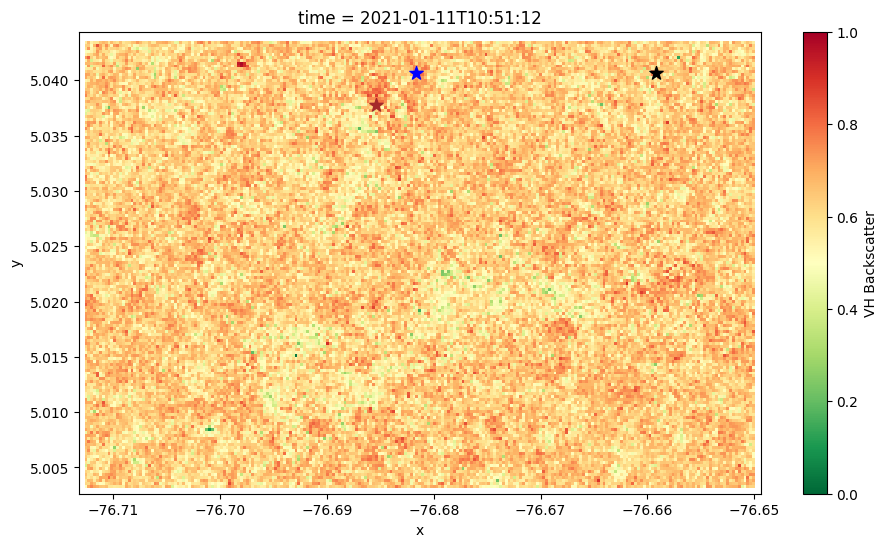

In [83]:
#plotting an image from the time series
#tsvis = ts_vv.VV_fdb.isel(time=60)
tsvis = ts_vv.rfdi.isel(time=0)
#tsvis.plot(figsize=(11, 6),cmap="gray", vmin = -20, vmax = -5, cbar_kwargs={'label': 'VV backscatter in db'})

x1 = -76.6816834
x2 = -76.659217
x3 = -76.6854058
y1 = 5.0406915
y2 = 5.0377580

fig, ax = plt.subplots(figsize=(11, 6))

#ax.plot = tsvis.plot(cmap="Greys", vmin = 0, vmax = 0.3, cbar_kwargs={'label': 'VH Backscatter'})
ax.plot = tsvis.plot(cmap="RdYlGn_r", vmin = 0, vmax = 1, cbar_kwargs={'label': 'VH Backscatter'})



ax.scatter(x1, y1, marker='*', c='blue', s=100)
ax.scatter(x2, y1, marker='*', c='black', s=100)
ax.scatter(x3, y2, marker='*', c='brown', s=100)
#plt.show()
#fig.clear()
#ax.set(title = 'Backscatter VV band for Lat = 5.0375 Lon = [-76.6821, -76.6592]')
       
    
#    plt.plot([3, 4], [6, 7], marker='*', ls='none', ms=20)
       #ax.plot(tsvis, cmap="gray", vmin = -20, vmax = -5, cbar_kwargs={'label': 'VV backscatter in db'})
#ax.addPoint(scat, [5.030,-76.69], 'pink')
#ax.set(title = 'Backscatter VV band for Lat = 5.0375 Lon = [-76.6821, -76.6592]',
#      xlabel = 'Time',
#      ylabel = 'Backscatter VV band')


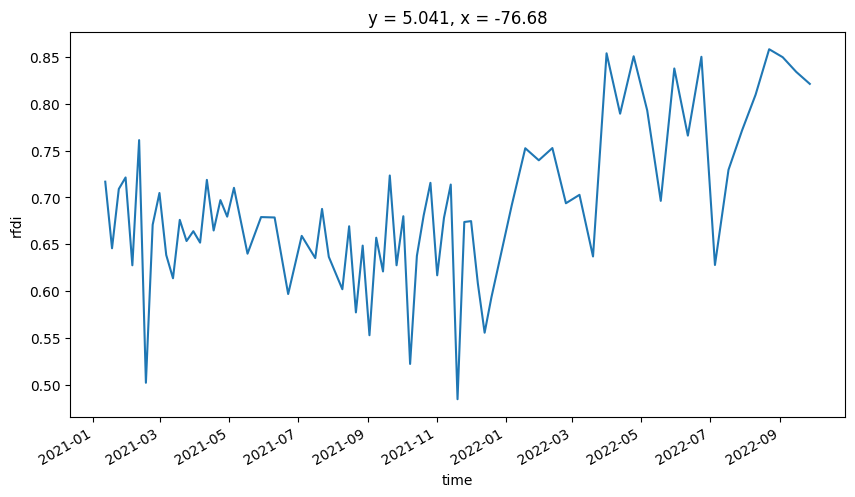

In [98]:
#ts1d = ts_vv.VH_fdb.isel(y = 35 , x = [110,150,200])
#ts1d.plot(figsize=(10, 5))

ts1d = ts_vv.rfdi.isel(y = 13 , x = 116)
ts1d.plot.line(x='time', figsize=(10, 5))

ts3d = ts_vv.rfdi.isel(y = 13 , x = 200)
#ts3d.plot.line(x='time', figsize=(10, 5))

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Radar Forest Degradation Index')]

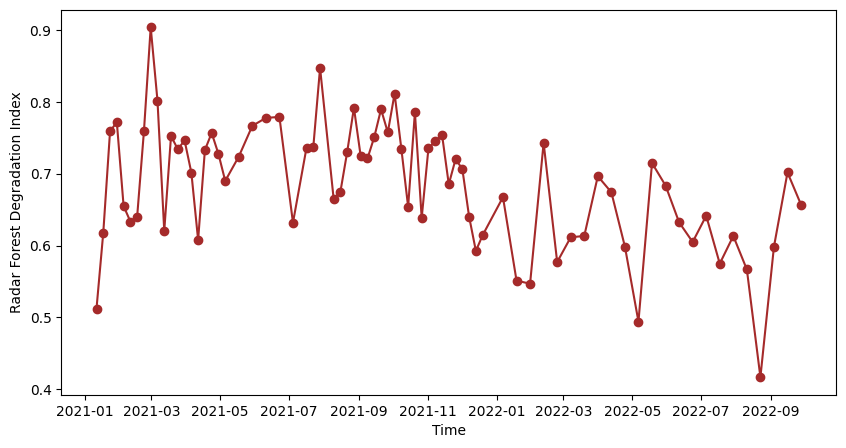

In [99]:
#plottin a place which was deforested before the time series period and still remains deforested
ts2d = ts_vv.rfdi.isel(y = 25 , x = 105)
#ts1d = ts_vv.rfdi.isel(y = 100 , x = 37)
#ts1d.plot.line(x='time', figsize=(10, 5), color = 'brown')

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(ts2d.time, ts2d, marker="o", color = 'brown')

ax.set(
      xlabel = 'Time',
      ylabel = 'Radar Forest Degradation Index')

In [96]:
ts1d.x


<xarray.DataArray 'x' (x: 2)>
array([-76.681855, -76.659217])
Coordinates:
    y        float64 5.041
  * x        (x) float64 -76.68 -76.66

In [97]:
ts2d.x

<xarray.DataArray 'x' ()>
array(-76.68481898)
Coordinates:
    y        float64 5.038
    x        float64 -76.68

In [101]:
ts3d.x

<xarray.DataArray 'x' ()>
array(-76.65921699)
Coordinates:
    y        float64 5.041
    x        float64 -76.66

In [ ]:
ts1d

[Text(0.5, 1.0, 'Modified Radar forest degradation index for blue, black and brown points '),
 Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'mRFDI')]

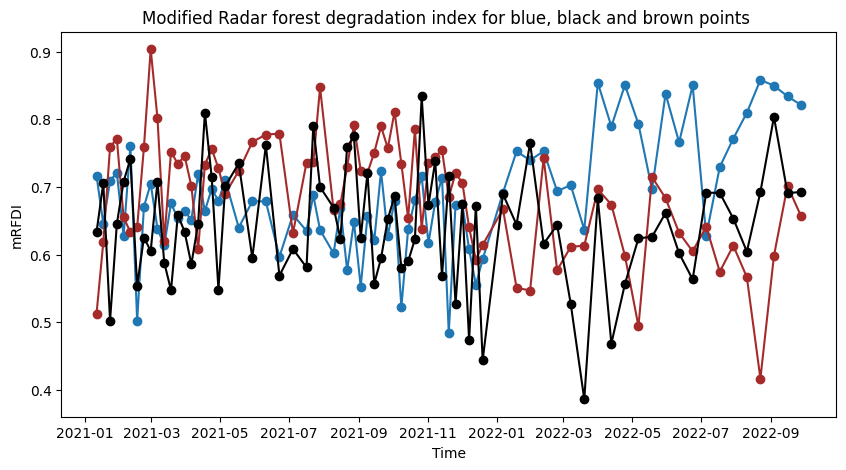

In [103]:
#for plotting from the DataArrays


fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(ts1d.time, ts1d, marker="o")
ax.plot(ts2d.time, ts2d, marker="o", color = 'brown')
ax.plot(ts3d.time, ts3d, marker="o", color = 'black')
ax.set(title = 'Modified Radar forest degradation index for blue, black and brown points ',
      xlabel = 'Time',
      ylabel = 'mRFDI')



#colormap = numpy.array(['r', 'g', 'b'])
 
# depict illustration
#plt.scatter(a[0], a[1], s=100, c=colormap[categories])
#plt.show()


In [ ]:
#trabsforming to pandas just for checking

df_t = ts.to_dataframe()
df_t

### Operation for Cusum algorithm

In [105]:
# get timeseries mean
dsmean = ts_vv.mean(dim='time', keep_attrs=True) #replace the time series Xarraydataset for other bands
dsmean

<xarray.Dataset>
Dimensions:  (y: 155, x: 237)
Coordinates:
  * y        (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x        (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
Data variables:
    rfdi     (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    transform:               (0.00026949458523585647, 0.0, -76.71325065489796...
    crs:                     +proj=longlat +datum=WGS84 +no_defs=True
    res:                     (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [ ]:
dsmean2 = ts_vv.mean() #replace the time series Xarraydataset for other bands
dsmean2

In [106]:
#get time series residual
Res = ts_vv-dsmean # replace the time series Xarraydataset for other bands
Res

<xarray.Dataset>
Dimensions:  (time: 74, y: 155, x: 237)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-11T10:51:12 ... 2022-09-27T10:51:37
  * y        (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x        (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
Data variables:
    rfdi     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

In [107]:
# get time series cumulative sum
#from Arraydataset to DataArray

Residuals = Res.to_array()


In [108]:
S = Residuals.cumsum(dim="time") 
S

<xarray.DataArray (variable: 1, time: 74, y: 155, x: 237)>
array([[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         ...,
         [ 0.0000000e+00,  0.0000000e+00, -1.3113451e-01, ...,
          -2.0650268e-02,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
...
          -3.7609875e-02,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  4.4107437e-06, ...,
          -2.7418137e-06,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],
      dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2021-01-11T10:51:12 ... 2022-09-27T10:51:37
  * y         (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x         (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
  * variable  (variable) object 'rfdi'

In [109]:
# get maximum of the cumulative sum
Smax= S.max(dim="time")     
Smax

<xarray.DataArray (variable: 1, y: 155, x: 237)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.15017372, ..., 0.4083402 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * y         (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x         (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
  * variable  (variable) object 'rfdi'

In [110]:
#get minimum of the cusum
Smin = S.min(dim='time')
Smin

<xarray.DataArray (variable: 1, y: 155, x: 237)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        , -0.7683215 , ..., -0.20033544,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)
Coordinates:
  * y         (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x         (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
  * variable  (variable) object 'rfdi'

In [111]:
#get the diff

Sdiff = S.max(dim ='time') - S.min(dim ='time')
Sdiff

<xarray.DataArray (variable: 1, y: 155, x: 237)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.91849524, ..., 0.6086756 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * y         (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x         (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
  * variable  (variable) object 'rfdi'

In [112]:
#checkin the diff in specific location
ts_diff = Sdiff.isel(y = 35 , x = 102)
ts_diff

<xarray.DataArray (variable: 1)>
array([2.0088038], dtype=float32)
Coordinates:
    y         float64 5.035
    x         float64 -76.69
  * variable  (variable) object 'rfdi'

In [123]:
# the threshold is calculated as 90th percentile of the CuSum max
#the thershold retrieves the pixels considered as change, every pixel where Smax is over percentile 90th
threshold = np.percentile(Smax, 90) 
threshold

0.7214799642562864

In [155]:
# filter cumulative sum array by year of interest
year = "2022"
Sfilt_time = S.sel(time=year) 
Sfilt_time

<xarray.DataArray (variable: 1, time: 23, y: 155, x: 237)>
array([[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         ...,
         [ 0.0000000e+00,  0.0000000e+00, -5.5289954e-01, ...,
           1.0737595e-01,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
...
          -3.7609875e-02,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  4.4107437e-06, ...,
          -2.7418137e-06,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],
      dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2022-01-06T10:51:18 ... 2022-09-27T10:51:37
  * y         (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x         (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
  * variable  (variable) object 'rfdi'

In [156]:
# convert to DOY
Sfilt_time['time'] = Sfilt_time["time.dayofyear"]


In [ ]:
Sfilt_time

In [ ]:
S

In [157]:
# spatially filter by 99th percentile
Sfilt_n = Sfilt_time.where(Sfilt_time>= threshold,np.nan)
Sfilt_n

<xarray.DataArray (variable: 1, time: 23, y: 155, x: 237)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * time      (time) int64 6 18 30 42 54 66 78 ... 198 210 222 234 246 258 270
  * y         (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x         (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
  * variable  (variable) object 'rfdi'

In [ ]:
#this replaces the cell above
# spatially filter by 90th percentile without converting to dayofyear
S90 = Sfilt_time.where(S>= threshold,np.nan)
S90

In [158]:
# determine where you have valid data
mask = Sfilt_n['time'].isel(time=0).notnull()  
mask

<xarray.DataArray 'time' ()>
array(True)
Coordinates:
    time     int64 6

In [ ]:
masked = S90['time'].isel(time=0).notnull()
masked

In [159]:
#convert Nan to calculate maximum
Sfilt_n2 = Sfilt_n.fillna(-9999)
Sfilt_n2

<xarray.DataArray (variable: 1, time: 23, y: 155, x: 237)>
array([[[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         ...,
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

        [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         ...,
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

        [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         ...,
...
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

        [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         ...,
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],

        [[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         ...,
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
         [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]]],
      dtype=float32)
Coordinates:
  * time      (time) int64 6 18 30 42 54 66 78 ... 198 210 222 234 246 258 270
  * y         (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x         (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
  * variable  (variable) object 'rfdi'

In [ ]:
S90filt = S90.fillna(-9999)
S90filt

In [160]:
# get the date where the curve reaches the maximum value
Sfilt_max = Sfilt_n2.isel(time = Sfilt_n2.argmax('time')).where(mask) 
Sfilt_max


<xarray.DataArray (variable: 1, y: 155, x: 237)>
array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]],
      dtype=float32)
Coordinates:
  * y         (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x         (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
  * variable  (variable) object 'rfdi'

In [ ]:
# get the date where the curve reaches the maximum value
S90filt_max = S90filt.isel(time = S90filt.argmax('time')).where(masked) 
S90filt_max

In [161]:
max_values = Sfilt_max.where(Sfilt_max> -9999,np.nan)
max_dates = Sfilt_n.idxmax(dim="time")

max_values

<xarray.DataArray (variable: 1, y: 155, x: 237)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y         (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x         (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
  * variable  (variable) object 'rfdi'

In [162]:
max_dates

<xarray.DataArray 'time' (variable: 1, y: 155, x: 237)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y         (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x         (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
  * variable  (variable) object 'rfdi'

In [163]:
max_values.name = 'Smax'
max_dates.name = 'doy'

In [ ]:
# the same that above but with date format

max90_values = S90filt_max.where(S90filt_max> -9999,np.nan)
max90_dates = S90.idxmax(dim="time")

max90_values.name = 'Smax90'
max90_dates.name = 'date'

In [ ]:
max90_values

In [ ]:
max90_dates

In [ ]:
#convert from datetime64[ns] type to string into the DataArray
#max90_dates.dt.strftime("%Y-%m-%d")
#max90_dates


In [ ]:
#convert maxdates xarray to pd dataframe

dates_df = max90_dates.to_dataframe()
dates_df
#dates_df3 = max90_dates.to_dataframe().reset_index()
#dates_df3

In [ ]:
#reset the index
max_dates_df = dates_df.reset_index()
max_dates_df


In [ ]:
#reorganizing the index using X and Y
del dates_df
max_dates_df2 = max_dates_df.set_index(['y','x'])
max_dates_df2


In [ ]:
#drop the column variable
del max_dates_df
max_dates_df3 = max_dates_df2.drop(['variable'], axis=1)
max_dates_df3


In [ ]:
#convert to datetime64 to string
del max_dates_df2
max_dates_df4 = max_dates_df3['date'].dt.strftime('%Y-%m-%d')
max_dates_df4


In [ ]:
#converting dates to integer values
#lvalues = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46, 
            47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74]

#S1_vv_dates

#Dict_dates = dict(zip(S1_vv_dates, lvalues))
#Dict_dates

In [ ]:
#just in case the dataframe is not a dataframe, it is a series
#new=cd_df.to_frame()
#new
del max_dates_df3
max_dates_df5 = max_dates_df4.to_frame()
max_dates_df5

In [ ]:
type(max_dates_df5)

In [ ]:
max_dates_df5.dtypes

In [ ]:
#function to convert from YYYY-mm-dd to float YYYY,yyyy

#del max_dates_df4

def YearAndFraction(row):
            
    if row["date"] in S1_vv_dates:
        
        year = float (row[0][0:4])            
        #print(row[0])
    
        month = float (row[0][5:7])
        
        day = float (row[0][8:10])
        
        frm = (month*(1/12))-(1/12)

        frd = (day/365)
        value = year+frm+frd
        #print(value)
        max_dates_df5['date'] = max_dates_df5['date'].replace(row['date'], value)

max_dates_df5.apply(YearAndFraction, axis=1)
#max_dates_df4.apply(YearAndFraction)




In [ ]:
#max_dates_df6 = max_dates_df5['date'].astype('float64')

#max_dates_df5 = max_dates_df5.astype({'date': 'float'})

In [ ]:
#convert from df to Xarray dataset
datesDetection = max_dates_df5.to_xarray()

In [ ]:
#del max_dates_df5
datesDetection

In [ ]:
# to DataArray
datesOfChange=datesDetection.to_array()
datesOfChange

In [ ]:
#nuevo = datesDetection.transpose('y','x','variable')
#nuevo

In [ ]:
max90_values

In [ ]:
#replacing dates for integer values

#new['date'] = new['date'].replace(Dict_dates)

#def rastervalues(row):
    
#    if not row["date"] in lvalues:
#        dates_df['date'] = dates['date'].replace(row['date'], '')

#dates_df.apply(TipoInst, axis=1)

In [ ]:
df1 = '/home/sepal-user/My_files/Outputs/DatesChanged_14.csv' 
max_dates_df5.to_csv(df1, sep=',')

In [164]:


intensityName = 'D:\\NOVAIMS\\TESIS_PROJECT\\Data\\Outputs\\test1_p90\\Smax_rfdi.tif'   # path to your folder for Smax intensity image
dateName = 'D:\\NOVAIMS\\TESIS_PROJECT\\Data\\Outputs\\test1_p90\\Dates_rfdi.tif'       # path to your folder for Date image

max_values_raster = max_values.rio.write_crs(crs)
max_values_raster.rio.to_raster(intensityName,compress='LZMA')

max_dates_raster = max_dates.rio.write_crs(crs)
max_dates_raster.rio.to_raster(dateName,compress='LZMA')

In [ ]:
#max90_values
#max90_dates


intensityName = 'D:\\NOVAIMS\\TESIS_PROJECT\\Data\\Outputs\\test1_p90\\SmaxVH.tif'   # path to your folder for Smax intensity image
dateName = 'D:\\NOVAIMS\\TESIS_PROJECT\\Data\\Outputs\\test1_p90\\DatesVH.tif'        # path to your folder for Date image

max_values_raster = max90_values.rio.write_crs(crs)
max_values_raster.rio.to_raster(intensityName,compress='LZMA')

max_dates_raster = max90_dates.rio.write_crs(crs)
max_dates_raster.rio.to_raster(dateName,compress='LZMA')

In [ ]:
max_dates_df5

### Analysis plots cusum

Text(0, 0.5, 'mRFDI')

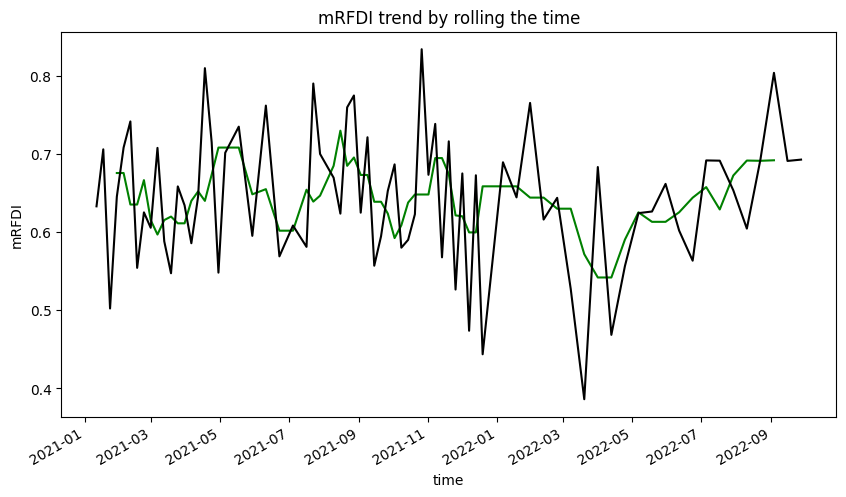

In [118]:
#plotting original time series and applying rolling() to see the trend
#ts4d = ts_vv.rfdi.isel(y = 100 , x = 37)
tsR= ts3d.rolling(time = 6, center=True).median()
tsR.plot(figsize=(10, 5),c='green')
_=ts3d.plot(c='black')
plt.title('mRFDI trend by rolling the time')
plt.ylabel('mRFDI')
#tsR.set(title = 'VH backscatter for blue, orange and brown points ')

#ts1d.plot.line(x='time', figsize=(10, 5))


#fig, ax = plt.subplots(figsize=(10, 5))

#ax.plot(ts1d.time, ts1d, marker="o")
#ax.plot(ts2d.time, ts2d, marker="o", color = 'brown')
#ax.set(title = 'VH backscatter for blue, orange and brown points ',
#      xlabel = 'Time',
#      ylabel = 'Backscatter in db')


In [115]:
ts4d.x

<xarray.DataArray 'x' ()>
array(-76.70314461)
Coordinates:
    y        float64 5.017
    x        float64 -76.7

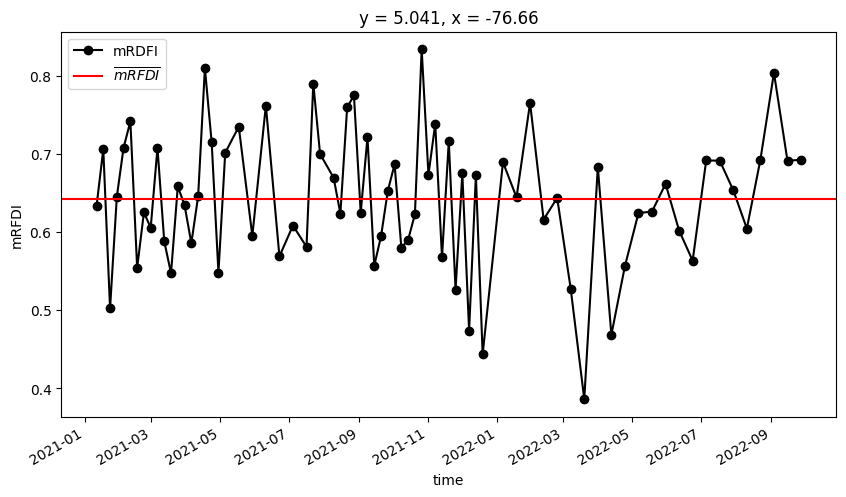

In [119]:
#plotting time series + mean
tsmean = ts3d.mean()

fig, ax= plt.subplots(figsize=(10,5))
ts3d.plot(color = 'black', marker="o")
#plt.ylabel('$\gamma^0$ [dB] -- VH band')
plt.ylabel('mRFDI')
ax.axhline(tsmean, color = 'red')
_=plt.legend(['mRDFI', '$\overline{mRFDI}$'])




In [ ]:
tsmean = ts1d.mean()

In [ ]:
ts1d

In [ ]:
#plotting residuals
#tsRes = Res.rfdi.isel(y = 100 , x = 37)
tsRes = Res.VH_fdb.isel(y = 100 , x = 37)

In [ ]:
tsRes.plot.line(x='time',figsize=(10,5), marker = "o")

In [ ]:
tsRes

Text(0, 0.5, 'Cusum')

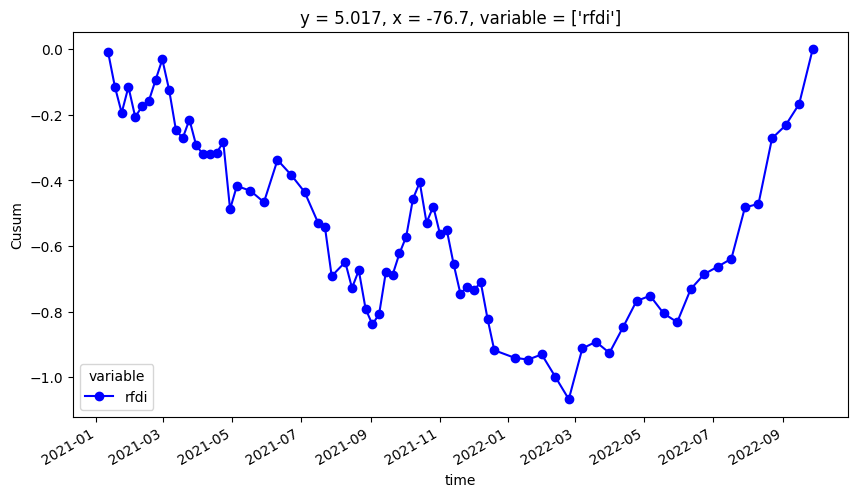

In [122]:
#plotting cusum
ts_S = S.isel(y = 100 , x =37)
ts_S.plot.line(x='time', figsize=(10,5), color = 'blue', marker = "o")
#plt.title('Cumulative sums of residuals at lat = 5.017, long = -76.703')
plt.ylabel('Cusum')

#ts1d = ts_vv.VV_fdb.isel(y = 13 , x = [116,200])
#ts1d.plot.line(x='time', figsize=(10, 5))

#fig, ax = plt.subplots(figsize=(10, 5))

#ax.plot(ts_S.time, ts_S, marker="o")

#ax.set(title = 'Cumsum for Lat = 5.0408 Lon = -76.6816834',
#      xlabel = 'Time',
#      ylabel = 'Cumsum of residuals')

In [ ]:
ts_S

In [ ]:
ts_S.isel(time=53)

In [ ]:
ts_S.argmax('time')
#tsvis = ts_vv.VV_fdb.isel(time=0)
#max(dim="time")

In [ ]:
ts_S_df = ts_S.to_dataframe(name="S")

In [ ]:
ts_S_df.head(n=60)

In [131]:
Smax1c

<xarray.DataArray (variable: 1)>
array([1.3113022e-06], dtype=float32)
Coordinates:
    y         float64 5.017
    x         float64 -76.7
  * variable  (variable) object 'rfdi'

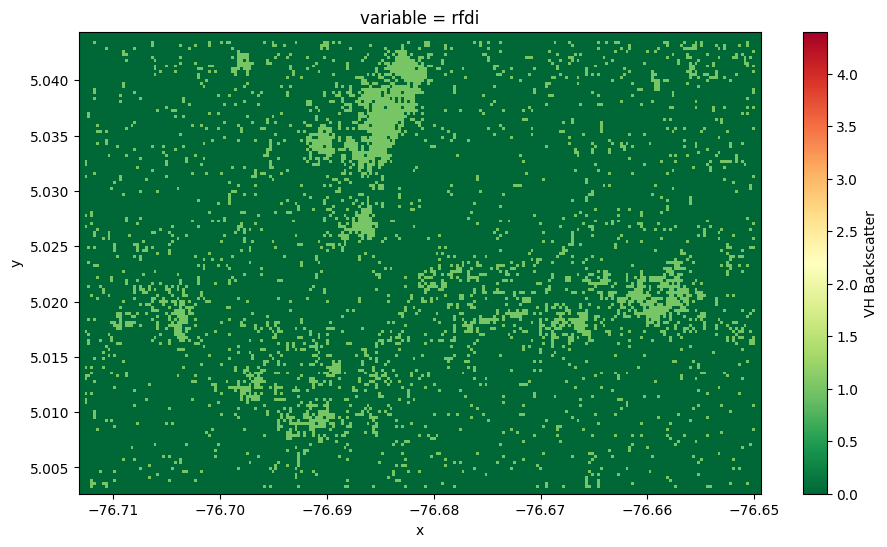

In [192]:
#slicing the Smx and S for plotting just on 2022
#ts_Smax_2022 = Smax.sel(time=slice('2022-01-01', '2022-02-01'))
#ts_vv_jan

Smax1c = (Sdiff > 1.062)

#Smax1c.plot.line()

fig, ax = plt.subplots(figsize=(11, 6))

ax.plot = Smax1c.plot(cmap="RdYlGn_r", vmin = 0 , vmax = 4.4, cbar_kwargs={'label': 'VH Backscatter'})


#ts_S.plot.line(x='time', figsize=(10,5), color = 'blue', marker = "o")


#tsvis = ts_vv.rfdi.isel(time=0)
#tsvis.plot(figsize=(11, 6),cmap="gray", vmin = -20, vmax = -5, cbar_kwargs={'label': 'VV backscatter in db'})

#x1 = -76.6816834
#x2 = -76.659217
#x3 = -76.6854058
#y1 = 5.0406915
#y2 = 5.0377580

#fig, ax = plt.subplots(figsize=(11, 6))

#ax.plot = tsvis.plot(cmap="Greys", vmin = 0, vmax = 0.3, cbar_kwargs={'label': 'VH Backscatter'})
#ax.plot = tsvis.plot(cmap="RdYlGn_r", vmin = 0, vmax = 1, cbar_kwargs={'label': 'VH Backscatter'})



#ax.scatter(x, y, marker='*', c='blue', s=100)
#ax.scatter(x2, y1, marker='*', c='black', s=100)
#ax.scatter(x3, y2, marker='*', c='brown', s=100)

In [166]:
Smax

<xarray.DataArray (variable: 1, y: 155, x: 237)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.15017372, ..., 0.4083402 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * y         (y) float64 5.044 5.044 5.044 5.043 ... 5.004 5.003 5.003 5.003
  * x         (x) float64 -76.71 -76.71 -76.71 -76.71 ... -76.65 -76.65 -76.65
  * variable  (variable) object 'rfdi'

In [147]:
Sdiff.min()

<xarray.DataArray ()>
array(0., dtype=float32)

In [189]:
#trying for rfdi with the Smin

threshold_dif = np.percentile(Sdiff, 90) 
threshold_dif

1.0623680114746092

### Testing different windows of analysis

### January

In [ ]:
# slice the time series, we are only interested in deforestation after 2022-01-01,
#but the data before it, serves as historical background. We captured that background with the cusum  

ts_vv_jan = ts_vv.sel(time=slice('2021-01-01', '2022-02-01'))
ts_vv_jan

In [ ]:
#operations for cusum
# get timeseries mean
mean_jan = ts_vv_jan.mean(dim='time', keep_attrs=True)
#get time series residual
Res_jan = ts_vv_jan-mean_jan

Residuals_jan = Res_jan.to_array()
#cusum
Sjan = Residuals_jan.cumsum(dim="time") 

# get maximum of the cumulative sum
Smax_jan= Sjan.max(dim="time")     


threshold_jan = np.percentile(Smax_jan, 90) 
threshold_jan



In [ ]:
#plotting for the specific location in analysis

#plotting time series + mean
ts_jan = ts_vv_jan.VH_fdb.isel(y = 100 , x = 37)

ts_jan_mean = ts_jan.mean(dim='time')

fig, ax= plt.subplots(figsize=(10,5))
ts_jan.plot(color = 'blue', marker="o")
plt.ylabel('$\gamma^0$ [dB] -- VV band')
ax.axhline(ts_jan_mean, color = 'red')
_=plt.legend(['$\gamma^0$', '$\overline{\gamma^0}$'])

In [ ]:
#plotting cusum

ts_S_jan = Sjan.isel(y = 100 , x =37)
ts_S_jan.plot.line(x='time', figsize=(10,5), color = 'blue', marker = "o")


In [ ]:
#the date of maximum

ts_S_jan.argmax('time')

#ts_S_jan('time' == a)

In [ ]:
ts_S_jan.isel(time=26)

In [ ]:
ts_S_jan

In [ ]:

S_jan_df = ts_S_jan.to_dataframe(name="S_jan_df")

In [ ]:
S_jan_df

### Up to February

In [ ]:
# slice the time series, we are only interested in deforestation after 2022-01-01,
#but the data before it, serves as historical background. We captured that background with the cusum  
#prcp_clip.sel(time=slice(start_date, end_date))
ts_vv_feb = ts_vv.sel(time=slice('2021-01-01', '2022-03-01')) 
ts_vv_feb

In [ ]:
#operations for cusum
# get timeseries mean
mean_feb = ts_vv_feb.mean(dim='time', keep_attrs=True)
#get time series residual
Res_feb = ts_vv_feb-mean_feb

Residuals_feb = Res_feb.to_array()
#cusum
Sfeb = Residuals_feb.cumsum(dim="time") 

# get maximum of the cumulative sum
Smax_feb= Sfeb.max(dim="time")     


threshold_feb = np.percentile(Smax_feb, 90) 
threshold_feb



In [ ]:
#plotting for the specific location in analysis

#plotting time series + mean
ts_feb = ts_vv_feb.VH_fdb.isel(y = 100 , x = 37)

ts_feb_mean = ts_feb.mean()

fig, ax= plt.subplots(figsize=(10,5))
ts_feb.plot(color = 'blue', marker="o")
plt.ylabel('$\gamma^0$ [dB] -- VV band')
ax.axhline(ts_feb_mean, color = 'red')
_=plt.legend(['$\gamma^0$', '$\overline{\gamma^0}$'])

In [ ]:
#plotting cusum

ts_S_feb = Sfeb.isel(y = 100 , x =37)
ts_S_feb.plot.line(x='time', figsize=(10,5), color = 'blue', marker = "o")


In [ ]:
ts_S_feb

### Up to April

In [ ]:
ts_vv_apr = ts_vv.sel(time=slice('2021-01-01', '2022-05-01')) 
ts_vv_apr

In [ ]:
#operations for cusum
# get timeseries mean
mean_apr = ts_vv_apr.mean(dim='time', keep_attrs=True)
#get time series residual
Res_apr = ts_vv_apr-mean_apr

Residuals_apr = Res_apr.to_array()
#cusum
Sapr = Residuals_apr.cumsum(dim="time") 

# get maximum of the cumulative sum
Smax_apr= Sapr.max(dim="time")     


threshold_apr = np.percentile(Smax_apr, 90) 
threshold_apr

In [ ]:
#plotting for the specific location in analysis

#plotting time series + mean
ts_apr = ts_vv_apr.VH_fdb.isel(y = 100 , x = 37)

ts_apr_mean = ts_apr.mean()

fig, ax= plt.subplots(figsize=(10,5))
ts_apr.plot(color = 'blue', marker="o")
plt.ylabel('$\gamma^0$ [dB] -- VV band')
ax.axhline(ts_apr_mean, color = 'red')
_=plt.legend(['$\gamma^0$', '$\overline{\gamma^0}$'])

In [ ]:
#plotting cusum

ts_S_apr = Sapr.isel(y = 100 , x =37)
ts_S_apr.plot.line(x='time', figsize=(10,5), color = 'blue', marker = "o")

In [ ]:
Residuals_apr.isel(y = 100 , x =37)

In [ ]:
Sapr.isel(y = 100 , x =37)

### Up to June

In [ ]:
ts_vv_jun = ts_vv.sel(time=slice('2021-01-01', '2022-07-01')) 
ts_vv_jun

In [ ]:
#operations for cusum
# get timeseries mean
mean_jun = ts_vv_jun.mean(dim='time', keep_attrs=True)
#get time series residual
Res_jun = ts_vv_jun-mean_jun

Residuals_jun = Res_jun.to_array()
#cusum
Sjun = Residuals_jun.cumsum(dim="time") 

# get maximum of the cumulative sum
Smax_jun= Sjun.max(dim="time")     


threshold_jun = np.percentile(Smax_jun, 90) 
threshold_jun

In [ ]:
#plotting for the specific location in analysis

#plotting time series + mean
ts_jun = ts_vv_jun.VH_fdb.isel(y = 100 , x = 37)

ts_jun_mean = ts_jun.mean()

fig, ax= plt.subplots(figsize=(10,5))
ts_jun.plot(color = 'blue', marker="o")
plt.ylabel('$\gamma^0$ [dB] -- VV band')
ax.axhline(ts_jun_mean, color = 'red')
_=plt.legend(['$\gamma^0$', '$\overline{\gamma^0}$'])

In [ ]:
#plotting cusum

ts_S_jun = Sjun.isel(y = 100 , x =37)
ts_S_jun.plot.line(x='time', figsize=(10,5), color = 'blue', marker = "o")

### Up to August

In [ ]:
ts_vv_sep = ts_vv.sel(time=slice('2021-01-01', '2022-09-01')) 
ts_vv_sep

In [ ]:
#operations for cusum
# get timeseries mean
mean_sep = ts_vv_sep.mean(dim='time', keep_attrs=True)
#get time series residual
Res_sep = ts_vv_sep-mean_sep

Residuals_sep = Res_sep.to_array()
#cusum
Ssep = Residuals_sep.cumsum(dim="time") 

# get maximum of the cumulative sum
Smax_sep= Ssep.max(dim="time")     


threshold_sep = np.percentile(Smax_sep, 90) 
threshold_sep

In [ ]:
#plotting for the specific location in analysis

#plotting time series + mean
ts_sep = ts_vv_sep.VH_fdb.isel(y = 100 , x = 37)

ts_sep_mean = ts_sep.mean()

fig, ax= plt.subplots(figsize=(10,5))
ts_sep.plot(color = 'blue', marker="o")
plt.ylabel('$\gamma^0$ [dB] -- VV band')
ax.axhline(ts_sep_mean, color = 'red')
_=plt.legend(['$\gamma^0$', '$\overline{\gamma^0}$'])

In [ ]:
#plotting cusum

ts_S_sep = Ssep.isel(y = 100 , x =37)
ts_S_sep.plot.line(x='time', figsize=(10,5), color = 'blue', marker = "o")

In [ ]:
Res_sep.isel(y = 100 , x = 37)

In [ ]:
Ssep.isel(y = 100 , x = 37)

### using the slice for the monitoring period

In [ ]:
year = 2022 # year of interest

S_doi = S.isel(time = (S.time.dt.year == year))


In [ ]:
S_doi_jan = S_doi.sel(time=slice('2022-01-01', '2022-02-01')) 

In [ ]:
S_doi_jan.isel(time=0)

#masked = S90['time'].isel(time=0).notnull()
#masked

In [ ]:
#plotting cusum

ts_doi = S_doi_jan.isel(y = 13 , x =116)
ts_doi.plot.line(x='time', figsize=(10,5), color = 'blue', marker = "o")

In [ ]:
### idea loca usar media de monitoreo para toda la serie
# primero un año de datos hacia atras y calcular la media con esa
# segundo calcular la media para el periodo de monitoreo y comparar los valoes


ts_vv_h= ts_vv.sel(time=slice('2021-01-01', '2022-02-01'))
ts_vv_m= ts_vv.sel(time=slice('2022-01-01', '2022-05-01'))


In [ ]:
mh= ts_vv_h.mean(dim='time')
mh

In [ ]:
mm = ts_vv_m.mean(dim='time')
mm

In [ ]:
#get time series residual
Resm = ts_vv_m-mm
Resh = ts_vv_h-mh

Residuals_m = Resm.to_array()
Residuals_h = Resh.to_array()
#cusum
#Sjun = Residuals_jun.cumsum(dim="time") 

# get maximum of the cumulative sum
#Smax_jun= Sjun.max(dim="time")     


#threshold_jun = np.percentile(Smax_jun, 90) 
#threshold_jun

In [ ]:
Residuals_m

In [ ]:
Residuals_h

In [ ]:
Rfull = xr.concat([Residuals_h, Residuals_m], dim="time")

In [ ]:
Rfull

In [ ]:
#cusum
Sfull = Rfull.cumsum(dim="time") 

# get maximum of the cumulative sum
Smax_full= Sfull.max(dim="time")     


threshold_full = np.percentile(Smax_jun, 90) 
threshold_full

In [ ]:
ts_S_full = Sfull.isel(y = 13 , x =116)
ts_S_full.plot.line(x='time', figsize=(10,5), color = 'blue', marker = "o")